## 基于Pipeline的工作流

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',header=None)

In [2]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
from sklearn.preprocessing import LabelEncoder
X= df.loc[:,2:].values
y = df.loc[:,1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [4]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state = 1)

C:\Users\donaldxu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
#在Pipeline中继承数据转换及评估操作

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#Pipeline对象采用Tuple作为输入，每个Tuple中的第一个值为一个字符串，可以是任意的标识符，
#通过它来访问Pipeline中的元素，第二个值则为scikitlearn中的一个转换器或者评估器
#自动执行fit和tranform操作
pipe_lr = Pipeline([('scl',StandardScaler()),
                    ('pca',PCA(n_components=2)),
                    ('clf',LogisticRegression(random_state=1))
                   ])

pipe_lr.fit(X_train,y_train)
print('The Accuracy: %.3f' % pipe_lr.score(X_test,y_test))

The Accuracy: 0.947


## 使用K折交叉验证评估模型性能

In [6]:
#holdout方法
#k折交叉验证
#分层k折交叉验证对标准k折交叉验证做了稍许改进，类别比例在每个分块中得以保持
import numpy as np
from sklearn.cross_validation import StratifiedKFold

kfold = StratifiedKFold(y=y_train,n_folds=10,random_state=1)
scores=[]
for k,(train,test) in enumerate(kfold):
    pipe_lr.fit(X_train[train],y_train[train])
    score=pipe_lr.score(X_train[test],y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' %(k+1,np.bincount(y_train[train]),score))

print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))


Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956
CV accuracy: 0.950 +/- 0.029


In [7]:
#scikit-learn中也实现了k折交叉验证评分
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=1) # n_jobs: 任务分布到n个cpu, n_jobs=-1,表示所有CPU并行计算
print('CV accuracy scores: %s',scores)
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))

CV accuracy scores: %s [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


## 通过学习及验证曲线来调试算法

C:\Users\donaldxu\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


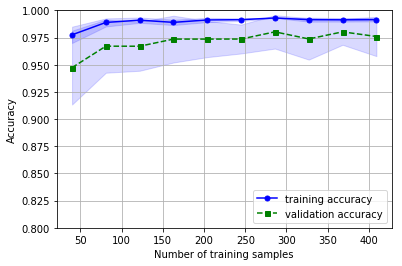

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

pipe_lr = Pipeline([('scl',StandardScaler()),('clf',LogisticRegression(penalty='l2',random_state=0))])
train_sizes,train_scores,test_scores = learning_curve(estimator=pipe_lr,
                                                     X=X_train,
                                                     y=y_train,
                                                     train_sizes = np.linspace(0.1,1.,10),
                                                     cv=10,
                                                     n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.plot(train_sizes,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean+train_std,
                train_mean-train_std,alpha=0.15,color='blue')
plt.plot(train_sizes,test_mean,color='green',linestyle='--',
         marker='s',markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean+test_std,
                test_mean-test_std,alpha=0.15,color='blue')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8,1.0])
plt.show()

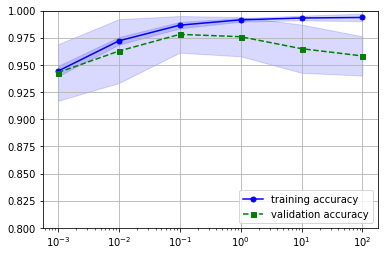

In [9]:
#通过验证曲线来判定
from sklearn.learning_curve import validation_curve
 
param_range = [0.001,0.01,0.1,1,10,100]
train_scores,test_scores = validation_curve(estimator=pipe_lr,
                                                      X=X_train,
                                                      y=y_train,
                                                      param_name='clf__C',
                                                      param_range=param_range,
                                                     cv=10)
train_mean=np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean=np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.plot(param_range,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(param_range,train_mean+train_std,
                train_mean-train_std,alpha=0.15,color='blue')
plt.plot(param_range,test_mean,color='green',linestyle='--',
         marker='s',markersize=5,label='validation accuracy')
plt.fill_between(param_range,test_mean+test_std,
                test_mean-test_std,alpha=0.15,color='blue')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.ylim([0.8,1.0])

plt.show()

## 使用网格搜索调优机器学习模型

In [10]:
#网格
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([('scl',StandardScaler()),('clf',SVC(random_state=1))])
param_range = [0.0001,0.001,0.01,0.1,1,10.0,100.0,1000.0]
param_grid = [{'clf__C':param_range,'clf__kernel':['linear']},
             {'clf__C':param_range,'clf__gamma':param_range,'clf__kernel':['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=1)
gs = gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

C:\Users\donaldxu\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.978021978021978
{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [13]:
#嵌套交叉验证
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=2)
scores=cross_val_score(gs,X,y,scoring='accuracy',cv=5)
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))

CV accuracy: 0.972 +/- 0.012


In [18]:
#使用嵌套交叉方法比较SVM和决策树
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                 param_grid=[{'max_depth':[1,2,3,4,5,6,7,None]}],
                 scoring='accuracy',
                 cv=5)
scores = cross_val_score(gs,X,y,scoring='accuracy',cv=5)
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))

CV accuracy: 0.917 +/- 0.009


## 性能评价指标

In [24]:
#混淆矩阵
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


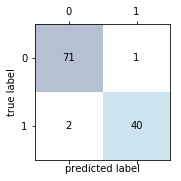

In [27]:
#matshow 可视化
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

### 准确率和召回率


预测误差(error, ERR)
$$ERR=\frac{FP+FN}{FP+FN+TP+TN}$$
预测准确率(accuracy, ACC)
$$ACC=\frac{TP+TN}{FP+FN+TP+TN} = 1-ERR$$

对于类别数量不均衡的分类问题，真正率和假正率是非常有用的性能指标<br>
真正率(TPR)
$$TPR=\frac{FP}{N} = \frac{FP}{FP+TN}$$
假正率(FPR)
$$FPR=\frac{TP}{P} = \frac{TP}{FN+TP}$$

精确率(precision, PRE)和召回率(recall, REC)是与真正率、真负率相关的性能指标，召回率即真正率<br>
$$PRE=\frac{TP}{TP+FP}$$ <br>
$$REC=TPR=\frac{TP}{P} = \frac{TP}{FN+TP}$$
实践中常用准确率与召回率的组合，称为F1分数：
$$F1=2\frac{PRE\times REC}{PRE+REC}$$

In [33]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score,f1_score
print('Precision: %.3f' % precision_score(y_true=y_test,y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test,y_pred=y_pred))
print('F1: %.3f' %f1_score(y_true=y_test,y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [35]:
#可以指定不同的正类类标，比如0，用make_score来构建自己的评分
from sklearn.metrics import make_scorer,f1_score
scorer = make_scorer(f1_score,pos_label=0)
gs=GridSearchCV(estimator=pipe_svc,
               param_grid=param_grid,
               scoring=scorer,
               cv=10)
scores=cross_val_score(gs,X,y,scoring='accuracy',cv=5)
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))

CV accuracy: 0.972 +/- 0.012


### 绘制ROC曲线

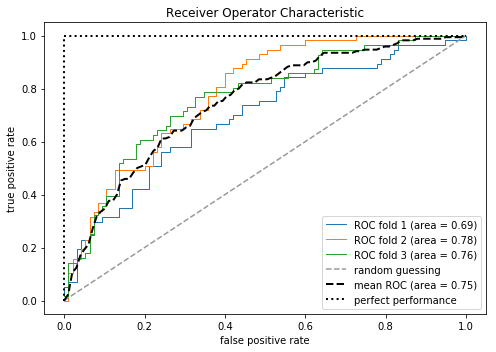

In [36]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', 
                                               random_state=0, 
                                               C=100.0))])

X_train2 = X_train[:, [4, 14]]

cv = StratifiedKFold(y_train, n_folds=3, random_state=1)

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], 
                         y_train[train]).predict_proba(X_train2[test])
    
    fpr, tpr, thresholds = roc_curve(y_train[test], 
                                     probas[:, 1], 
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, 
             tpr, 
             lw=1, 
             label='ROC fold %d (area = %0.2f)' 
                    % (i+1, roc_auc))

plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         color=(0.6, 0.6, 0.6), 
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], 
         [0, 1, 1], 
         lw=2, 
         linestyle=':', 
         color='black', 
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()